In [7]:
from __future__ import print_function
import six
import sys
import os
from optparse import OptionParser
from keras.models import load_model, Model, model_from_json
from argparse import ArgumentParser
from keras import backend as K
import numpy as np
# fix random seed for reproducibility
seed = 42
np.random.seed(seed)
import h5py
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
import itertools
sys.path.append(os.getcwd() + '/..')
from models.constraints import ZeroSomeWeights
from keras.utils.generic_utils import get_custom_objects
get_custom_objects().update({"ZeroSomeWeights": ZeroSomeWeights})
import yaml
from train import parse_config, get_features
from eval import makeRoc, plot_confusion_matrix
from layers.quantized_layers import Clip, BinaryDense, TernaryDense, QuantizedDense
from models.models import binary_tanh, ternary_tanh, quantized_relu

In [8]:
data_path = '../data/processed-pythia82-lhc13-all-pt1-50k-r1_h022_e0175_t220_nonu_truth.z'
import h5py
f = h5py.File(data_path, 'r')
treeArray = f['t_allpar_new'][()]
print(treeArray.dtype.names)

('j_ptfrac', 'j_pt', 'j_eta', 'j_mass', 'j_tau1_b1', 'j_tau2_b1', 'j_tau3_b1', 'j_tau1_b2', 'j_tau2_b2', 'j_tau3_b2', 'j_tau32_b1', 'j_tau32_b2', 'j_zlogz', 'j_c1_b0', 'j_c1_b1', 'j_c1_b2', 'j_c2_b1', 'j_c2_b2', 'j_d2_b1', 'j_d2_b2', 'j_d2_a1_b1', 'j_d2_a1_b2', 'j_m2_b1', 'j_m2_b2', 'j_n2_b1', 'j_n2_b2', 'j_tau1_b1_mmdt', 'j_tau2_b1_mmdt', 'j_tau3_b1_mmdt', 'j_tau1_b2_mmdt', 'j_tau2_b2_mmdt', 'j_tau3_b2_mmdt', 'j_tau32_b1_mmdt', 'j_tau32_b2_mmdt', 'j_c1_b0_mmdt', 'j_c1_b1_mmdt', 'j_c1_b2_mmdt', 'j_c2_b1_mmdt', 'j_c2_b2_mmdt', 'j_d2_b1_mmdt', 'j_d2_b2_mmdt', 'j_d2_a1_b1_mmdt', 'j_d2_a1_b2_mmdt', 'j_m2_b1_mmdt', 'j_m2_b2_mmdt', 'j_n2_b1_mmdt', 'j_n2_b2_mmdt', 'j_mass_trim', 'j_mass_mmdt', 'j_mass_prun', 'j_mass_sdb2', 'j_mass_sdm1', 'j_multiplicity', 'j_g', 'j_q', 'j_w', 'j_z', 'j_t', 'j_undef')


In [9]:
from collections import namedtuple
Option = namedtuple("MyStruct", "inputModel inputFile tree config jsonModel")

options = Option(
    #inputModel = '../weights/KERAS_conv2d_model_weights.h5',
    inputModel = '../conv2d_weights/KERAS_check_best_model.h5',
    inputFile = '../data/processed-pythia82-lhc13-all-pt1-50k-r1_h022_e0175_t220_nonu_withPars_truth.z',
    tree = 't_allpar_new',
    config = 'train_config_conv2d.yml',
    #jsonModel = '../weights/KERAS_conv2d_model.json'
    jsonModel = '../conv2d_weights/model.json'
)

print("Loading configuration from", options.config)
config = open(options.config, 'r')
yamlConfig =  yaml.load(config, Loader=yaml.FullLoader)
print(yamlConfig)

Loading configuration from train_config_conv2d.yml
{'Inputs': ['j1_etarot', 'j1_phirot', 'j1_ptrel', 'j_index'], 'Labels': ['j_g', 'j_q', 'j_w', 'j_z', 'j_t', 'j_index'], 'KerasModel': 'conv2d_model', 'KerasModelRetrain': 'conv2d_model_constraint', 'KerasLoss': 'categorical_crossentropy', 'L1Reg': 0.0001, 'NormalizeInputs': 0, 'InputType': 'Conv2D', 'BinsX': 40, 'MinX': -0.8, 'MaxX': 0.8, 'BinsY': 40, 'MinY': -1.0, 'MaxY': 1.0, 'MaxParticles': 100}


In [10]:
X_train_val, X_test, y_train_val, y_test, labels  = get_features(options, yamlConfig)

Keys: <KeysViewHDF5 ['t_allpar_new']>
load 24816
load 0
load 1000
load 2000
load 3000
load 4000
load 5000
load 6000
load 7000
load 8000
load 9000
load 10000
load 11000
load 12000
load 13000
load 14000
load 15000
load 16000
load 17000
load 18000
load 19000
load 20000
load 21000
load 22000
load 23000
load 24000
(24816, 40, 40, 1)
(19852, 40, 40, 1)
(4964, 40, 40, 1)


In [ ]:
train_sum = np.zeros((5, 40, 40))
for i in range(X_train_val.shape[0]):
    X = X_train_val[i].squeeze() # (40, 40)
    train_sum[np.argmax(y_train_val[i])] += X
#train_sum /= X_train_val.shape[0]
train_sum /= np.ndarray.max(train_sum)
for i in range(train_sum.shape[0]):
    XB = np.linspace(0,40,40)
    YB = np.linspace(0,40,40)
    X,Y = np.meshgrid(XB,YB)
    Z = train_sum[i]
    plt.imshow(Z,interpolation='none')
    plt.show()
    #hist, xedges, yedges = np.histogram2d(train_sum, y, weights=w, bins=(xbins,ybins))

In [16]:
json_file = open(options.jsonModel, 'r')
model = json_file.read()
json_file.close()
model = model_from_json(model, custom_objects={'ZeroSomeWeights':ZeroSomeWeights,
                                                           'BinaryDense': BinaryDense,
                                                           'TernaryDense': TernaryDense,
                                                           'QuantizedDense': QuantizedDense,
                                                           'binary_tanh': binary_tanh,
                                                           'ternary_tanh': ternary_tanh,
                                                           'quantized_relu': quantized_relu,
                                                           'Clip': Clip})
# load weights into new model
model.load_weights(options.inputModel)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 40, 40, 1)         0         
_________________________________________________________________
conv1_relu (Conv2D)          (None, 40, 40, 8)         976       
_________________________________________________________________
conv2_relu (Conv2D)          (None, 20, 20, 4)         292       
_________________________________________________________________
conv3_relu (Conv2D)          (None, 10, 10, 2)         74        
_________________________________________________________________
flatten_1 (Flatten)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                6432      
_________________________________________________________________
output_softmax (Dense)       (None, 5)                 165       
Total para

In [ ]:
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
from IPython.display import Image
#Image(filename='model_plot.png') 

## Using the weights provided

In [14]:
print("Plot ROC curve")
y_predict = makeRoc(X_test, labels, y_test, model)
plt.show()

print("Plot confusion matrix")
y_test_proba = y_test.argmax(axis=1)
y_predict_proba = y_predict.argmax(axis=1)

# Compute non-normalized confusion matrix
cnf_matrix = confusion_matrix(y_test_proba, y_predict_proba)
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[l.replace('j_','') for l in labels],
                          title='Confusion matrix')
plt.show()

print("Plot normalized confusion matrix")
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[l.replace('j_','') for l in labels], normalize=True,
                          title='Normalized confusion matrix')
plt.show()

Plot ROC curve


ValueError: Error when checking : expected conv2d_1_input to have shape (8, 8, 1) but got array with shape (40, 40, 1)

## Using the weight I trained

Plot ROC curve


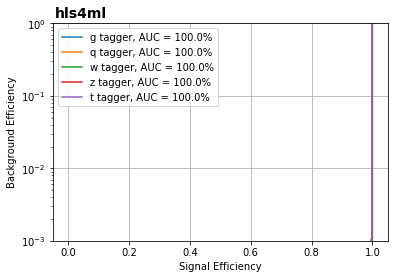

Plot confusion matrix


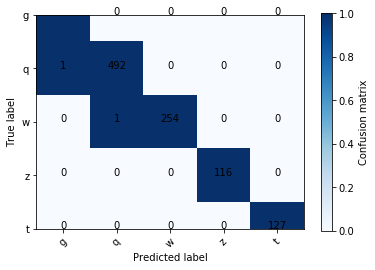

Plot normalized confusion matrix


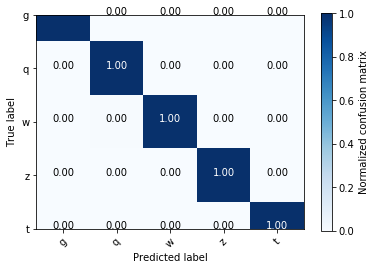

In [18]:
print("Plot ROC curve")
y_predict = makeRoc(X_test, labels, y_test, model)
plt.show()

print("Plot confusion matrix")
y_test_proba = y_test.argmax(axis=1)
y_predict_proba = y_predict.argmax(axis=1)

# Compute non-normalized confusion matrix
cnf_matrix = confusion_matrix(y_test_proba, y_predict_proba)
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[l.replace('j_','') for l in labels],
                          title='Confusion matrix')
plt.show()

print("Plot normalized confusion matrix")
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[l.replace('j_','') for l in labels], normalize=True,
                          title='Normalized confusion matrix')
plt.show()